# Vary direction of gravity vector with pitch

gravity vector direction varies with the pitch of the a/c, for now will say AoA and pitch are the same thing

In [2]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [26]:
# create instance of a simplified model parameters
p = dof2.Simplified2DofModel(inner_freq=2,inner_mass=4,mass_ratio=4)
p.Lambda.value = np.deg2rad(25)

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2 # + p.m*p.g*(-p.l*sym.sin(p.q[0]))

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_y(p.alpha_r).R_x(p.q[0])  # Line where the magic happens (added pitch rotation)
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system

In [27]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,50,201)
aoa = [0,2.5,5,7.5,10]

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(x):
    val = sM.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2
    

for i in aoa:
    p.alpha_r.value = np.deg2rad(i)    
    guess = [np.pi/2,0]
    for v in vs:
        p.V.value = v
        guess = minimize(ToMinimise,guess).x
        df = df.append({'aoa' : i, 'v' : v,'eta':guess[0],'q1':guess[1]} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

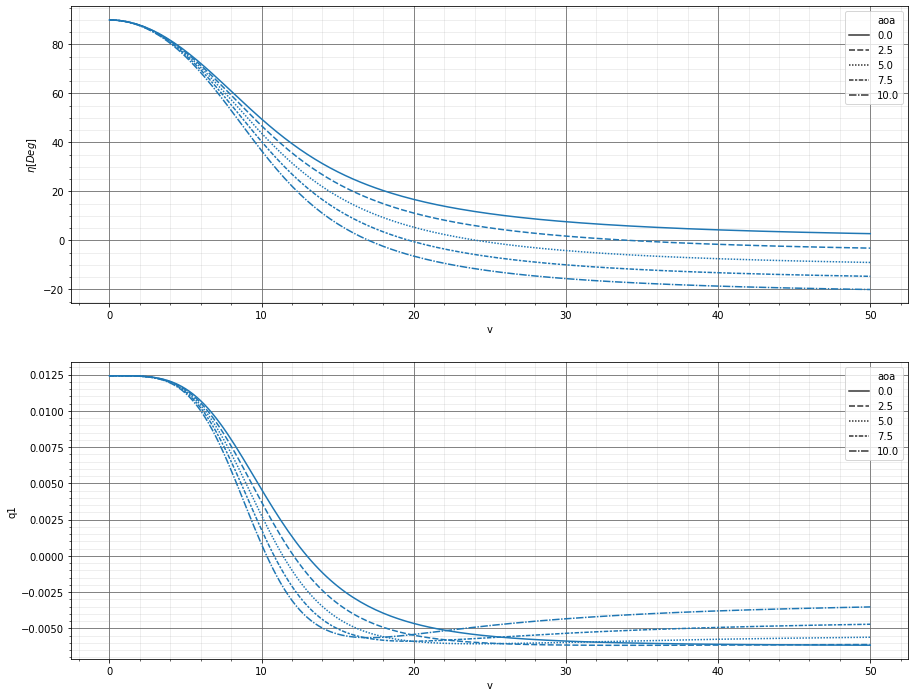

In [28]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])
sns.lineplot(data=df,y=r'$\eta [Deg]$',x='v',style='aoa',ax=axes[0])

sns.lineplot(data=df,y='q1',x='v',style='aoa',ax=axes[1])

for ax in axes:
    #ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [29]:
# create complete EoM
func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.alpha_r])

In [30]:
dat = df

flutdfv2 = pd.DataFrame()
for a in dat['aoa'].unique():
    #get relevent data points
    data = dat[dat['aoa']==a]
    
    for i in range(0,len(data)):  
        # get the fixed point
        lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['v'].iloc[i],np.deg2rad(a),lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp)
        # populate test specific data   
        jac_dat['V'] = data['v'].iloc[i]
        jac_dat['aoa'] = a
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,Mode,cn,Real,Imag,Frequency,Damping,Stable,V,aoa,lp
0,0,-0.000000+3.836013j,-2.081668e-16,3.836013,0.610520,-1.608123e-16,True,0.00,0.0,"[1.5707963267554577, 0, 0.012424503138314773, 0]"
1,1,0.000000+12.566371j,4.440892e-16,12.566371,2.000000,6.123234e-17,True,0.00,0.0,"[1.5707963267554577, 0, 0.012424503138314773, 0]"
2,0,-0.018040+3.836179j,-1.803961e-02,3.836179,0.610554,-4.702443e-03,True,0.25,0.0,"[1.5702138299001476, 0, 0.012424496369650413, 0]"
3,1,-0.000000+12.566371j,-8.214242e-10,12.566371,2.000000,-6.536676e-11,True,0.25,0.0,"[1.5702138299001476, 0, 0.012424496369650413, 0]"
4,0,-0.036079+3.836678j,-3.607923e-02,3.836678,0.610653,-9.403352e-03,True,0.50,0.0,"[1.568467114663816, 0, 0.012424405364731505, 0]"
...,...,...,...,...,...,...,...,...,...,...
2005,1,1.552274+13.793172j,1.552274e+00,13.793172,2.209109,1.118334e-01,False,49.50,10.0,"[-0.3489052404789546, 0, -0.003537829768670359..."
2006,0,-5.676717+16.279001j,-5.676717e+00,16.279001,2.743893,-3.292685e-01,False,49.75,10.0,"[-0.34934063840440877, 0, -0.00353277062199782..."
2007,1,1.546949+13.808684j,1.546949e+00,13.808684,2.211468,1.113308e-01,False,49.75,10.0,"[-0.34934063840440877, 0, -0.00353277062199782..."
2008,0,-5.691762+16.347249j,-5.691762e+00,16.347249,2.754938,-3.288176e-01,False,50.00,10.0,"[-0.34976938803352764, 0, -0.00352778360030994..."


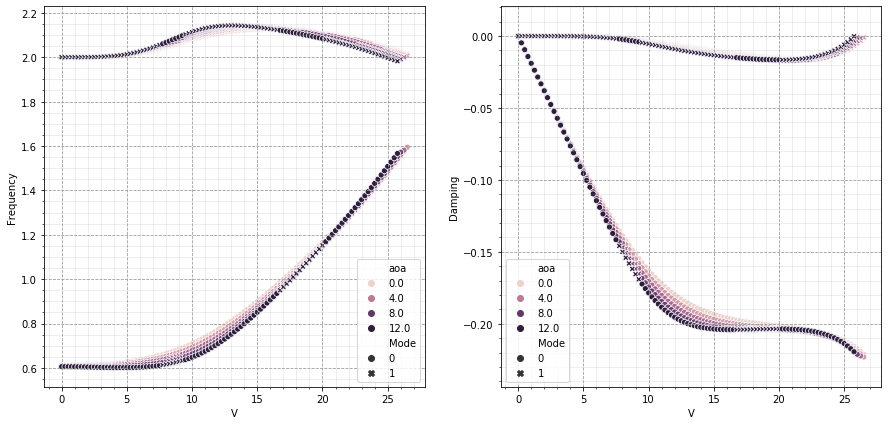

In [31]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
#data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='aoa',style='Mode',ax=axes[0])
sns.scatterplot(data=data,x='V',y='Damping',hue='aoa',style='Mode',ax=axes[1])
for i in [0,1]:
    #axes[i].set(xlim=(0,80))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

In [32]:
# get info for the first unstable point for each AoA

aoas = data['aoa'].unique()
idx = []

data = flutdfv2[~flutdfv2['Stable']]
for i in data['aoa'].unique():
    idx.append(data[data['aoa']==i].sort_values(by=['V'],axis=0).head(1).index[0])
    
res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res[['aoa','V','eta']]

,aoa,V,eta
214,0.0,26.75,9.561331
616,2.5,26.75,3.730197
1016,5.0,26.50,-1.996712
1416,7.5,26.25,-7.680108
1816,10.0,26.00,-13.213580
